In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

import os
import sys
import pickle

sys.path.append("../scripts")
from utils import Utils
from clean_data import DataCleaner
import sql_db as sql



In [47]:
cleaner = DataCleaner()
utility = Utils()

### User engagement and user experience score

In [48]:
cleaned_df=utility.load_data("../data/cleaned_data.csv")
user_engagement = utility.load_data("../data/user_engagement_metric.csv")
user_experience = utility.load_data("../data/user_experience_metrics.csv")

# since our csv file doesn't have a meta data of columns dtype, we manually convert ['bearer_id', 'imsi', 'msisdn/number', 'imei','handset_type'] to string once again
cleaned_df=cleaner.convert_to_string(cleaned_df)


In [49]:
user_engagement.head()

,msisdn/number,session_traffic(bytes),session_duration(ms),session_freq,cluster,score
0,3.197021e+12,232123971.0,325035.5,1.0,2,0.001210
1,3.360100e+10,878690574.0,116720.0,1.0,1,0.000058
2,3.360100e+10,156859643.0,181230.0,1.0,0,0.000965
3,3.360100e+10,595966483.0,134969.0,1.0,1,0.000036
4,3.360101e+10,422320698.0,49878.0,1.0,1,0.000073


In [50]:
user_experience.head()

,msisdn,handset_type,total_rtt(ms),total_tp(kbps),total_tcp(bytes),score
0,3.366496e+10,Samsung Galaxy A5 Sm-A520F,47.0,67.0,589679.5,0.472741
1,3.368185e+10,Samsung Galaxy J5 (Sm-J530),70.0,42.0,589679.5,0.472781
2,3.376063e+10,Samsung Galaxy A8 (2018),50.0,15.0,589679.5,0.472826
3,3.375034e+10,undefined,50.0,88.0,589679.5,0.472706
4,3.369980e+10,Samsung Sm-G390F,50.0,15.0,589679.5,0.472826


### Satisfaction score

In [51]:
user_engagement.rename(columns={"score": "engagement_score"}, inplace=True)
user_experience.rename(columns={"score": "experience_score"}, inplace=True)
user_engagement.rename(columns={"msisdn/number": "msisdn"}, inplace=True)

In [52]:
user_satisfaction_metrics = pd.merge(user_engagement, user_experience, on="msisdn")
user_satisfaction_metrics['satisfaction_score'] = user_satisfaction_metrics[['engagement_score','experience_score']].mean(axis=1)

In [53]:
score_df = user_satisfaction_metrics[['msisdn', 'satisfaction_score','engagement_score', 'experience_score']]

In [54]:
score_df['msisdn'] = score_df['msisdn'].astype(str)
score_df = cleaner.remove_nan_categorical(score_df)

C:\Users\natnael.masresha\AppData\Local\Temp\ipykernel_25952\3782924676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['msisdn'] = score_df['msisdn'].astype(str)


In [55]:
score_df.dropna(inplace=True)

### top 10 satisfied customers

In [56]:
top_10_satisfied = score_df.sort_values(by=['satisfaction_score'], ascending=False).head(10)
top_10_satisfied

,msisdn,satisfaction_score,engagement_score,experience_score
58703,33661003893.0,0.594846,0.000140,1.189552
130914,33761066497.0,0.588357,0.000131,1.176583
111821,33683692867.0,0.578779,0.000124,1.157435
119107,33698551167.0,0.528437,0.000018,1.056856
110578,33681782404.0,0.513988,0.000139,1.027836
79551,33664704919.0,0.513952,0.000117,1.027786
31456,33650128412.0,0.513551,0.000077,1.027026
135161,33762062356.0,0.513241,0.000126,1.026357
131121,33761124811.0,0.513052,0.000215,1.025889
108959,33679366089.0,0.512706,0.000028,1.025384


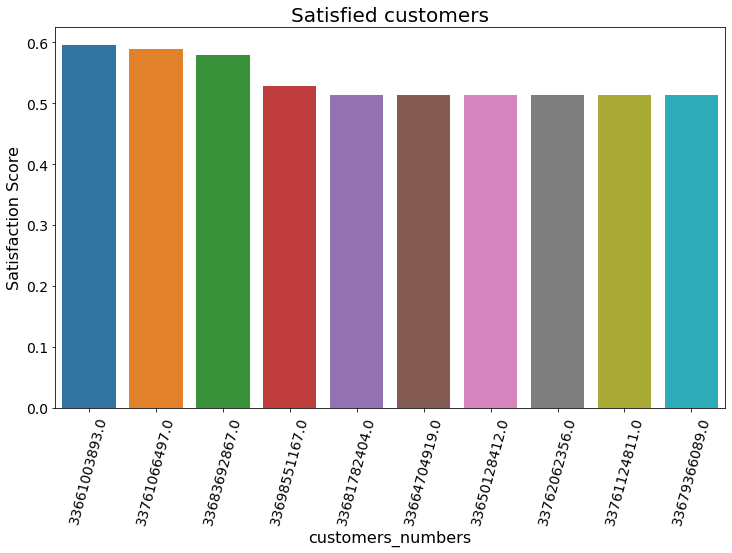

In [57]:
utility.plot_bar(df=top_10_satisfied[['msisdn','satisfaction_score']],title="Satisfied customers",x_col="msisdn",y_col="satisfaction_score",xlabel="customers_numbers",ylabel="Satisfaction Score")

the difference can't be clearly seen from the bar graph so it is better to visualize it with line graph

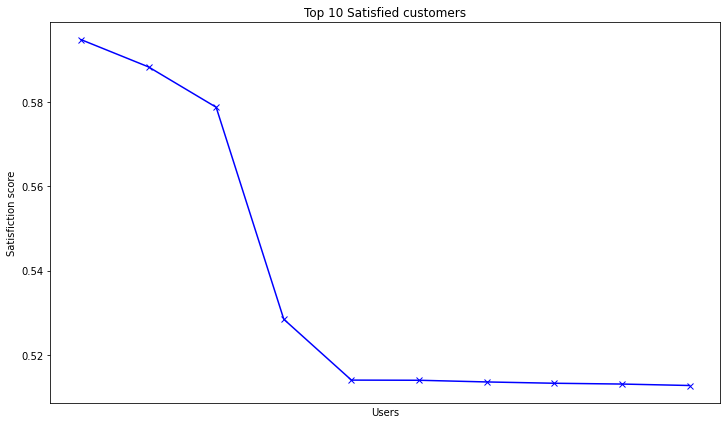

In [58]:
plt.figure(figsize=(12, 7))
plt.plot(top_10_satisfied['msisdn'],top_10_satisfied['satisfaction_score'],'bx-')
plt.xlabel('Users') 
plt.xticks(ticks=[''])
plt.ylabel('Satisfiction score') 
plt.title('Top 10 Satisfied customers')
plt.show()


### Modeling (Regression Model)

In [59]:
col_rearrange=['msisdn','handset_type','session_traffic(bytes)','session_duration(ms)','session_freq','total_rtt(ms)','total_tp(kbps)','total_tcp(bytes)','engagement_score','experience_score','satisfaction_score']
user_satisfaction_metrics_rearranged=user_satisfaction_metrics[col_rearrange]
user_satisfaction_metrics_rearranged

,msisdn,handset_type,session_traffic(bytes),session_duration(ms),session_freq,total_rtt(ms),total_tp(kbps),total_tcp(bytes),engagement_score,experience_score,satisfaction_score
0,3.197021e+12,Quectel Wireless. Quectel Ec25-E,2.321240e+08,325035.5,1.0,50.0,1.0,589679.5,0.001210,0.472848,0.237029
1,3.360100e+10,Huawei P20 Lite Huawei Nova 3E,8.786906e+08,116720.0,1.0,46.0,76.0,589679.5,0.000058,0.472726,0.236392
2,3.360100e+10,Apple iPhone 7 (A1778),1.568596e+08,181230.0,1.0,31.0,99.0,589679.5,0.000965,0.472688,0.236827
3,3.360100e+10,undefined,5.959665e+08,134969.0,1.0,50.0,97.0,589679.5,0.000036,0.472691,0.236364
4,3.360101e+10,Apple iPhone 5S (A1457),4.223207e+08,49878.0,1.0,84.0,248.0,22015.5,0.000073,0.461974,0.231023
...,...,...,...,...,...,...,...,...,...,...,...
148930,3.378998e+10,undefined,1.094693e+09,210389.0,2.0,69.0,162985.0,10096.0,0.000002,0.976720,0.488361
148931,3.378998e+10,undefined,1.094693e+09,210389.0,2.0,50.0,94.0,589679.5,0.000002,0.472696,0.236349
148932,3.379000e+10,Huawei Honor 9 Lite,7.146416e+08,8810.0,1.0,52.0,10365.0,218045.0,0.000178,0.426936,0.213557
148933,3.379000e+10,Apple iPhone 8 Plus (A1897),4.803073e+08,140988.0,1.0,40.0,116.0,589679.5,0.000103,0.472661,0.236382


In [60]:
user_satisfaction_metrics_rearranged.corr()

,msisdn,session_traffic(bytes),session_duration(ms),session_freq,total_rtt(ms),total_tp(kbps),total_tcp(bytes),engagement_score,experience_score,satisfaction_score
msisdn,1.000000,-0.004000,0.004798,-0.002766,-0.000381,-0.001879,-0.000243,0.019684,0.000823,0.000873
session_traffic(bytes),-0.004000,1.000000,0.588105,0.813259,-0.025085,0.142989,0.022887,-0.438212,-0.027747,-0.028862
session_duration(ms),0.004798,0.588105,1.000000,0.725577,-0.060421,0.020027,0.015398,-0.009490,0.040991,0.040962
session_freq,-0.002766,0.813259,0.725577,1.000000,-0.027437,0.178255,0.029475,-0.258920,-0.034764,-0.035420
total_rtt(ms),-0.000381,-0.025085,-0.060421,-0.027437,1.000000,0.001298,0.008199,-0.012409,0.019610,0.019576
total_tp(kbps),-0.001879,0.142989,0.020027,0.178255,0.001298,1.000000,0.132948,-0.116324,-0.139806,-0.140086
total_tcp(bytes),-0.000243,0.022887,0.015398,0.029475,0.008199,0.132948,1.000000,-0.015675,0.017945,0.017903
engagement_score,0.019684,-0.438212,-0.009490,-0.258920,-0.012409,-0.116324,-0.015675,1.000000,0.044073,0.046619
experience_score,0.000823,-0.027747,0.040991,-0.034764,0.019610,-0.139806,0.017945,0.044073,1.000000,0.999997
satisfaction_score,0.000873,-0.028862,0.040962,-0.035420,0.019576,-0.140086,0.017903,0.046619,0.999997,1.000000


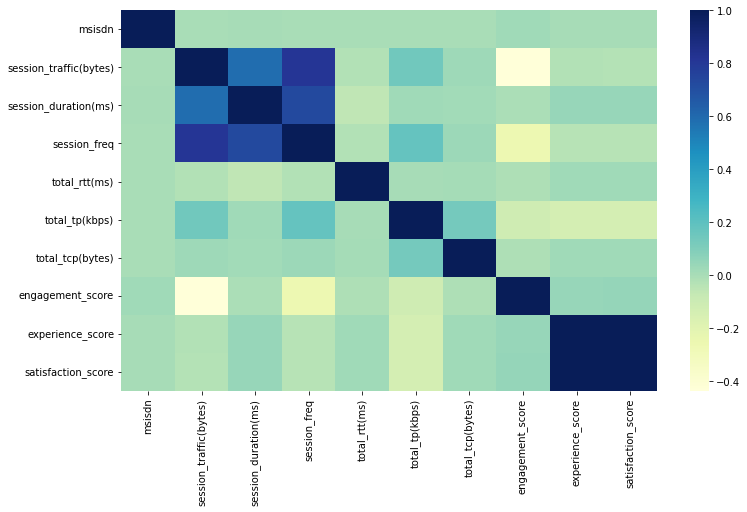

In [61]:
plt.figure(figsize=(12, 7))
sns.heatmap(user_satisfaction_metrics_rearranged.corr(),cmap="YlGnBu")
plt.show()

from the above heatmap we can see that total_rtt is less correlated with other features and msisdn, obviously is the least correlated with the others <br>
handset types was not included in the correlation because it is categorical column we shall apply label encoding

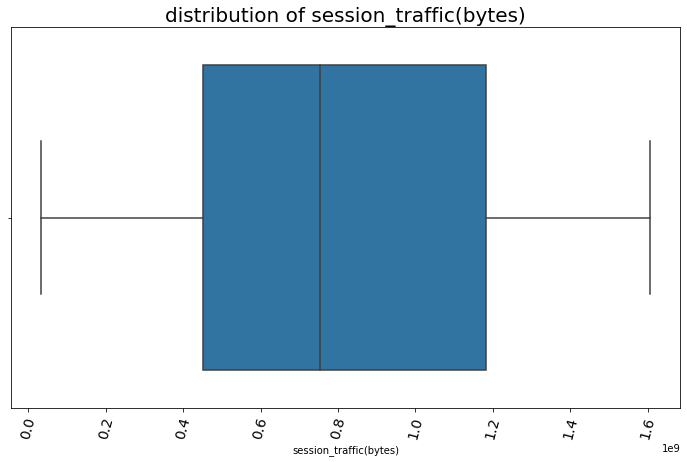

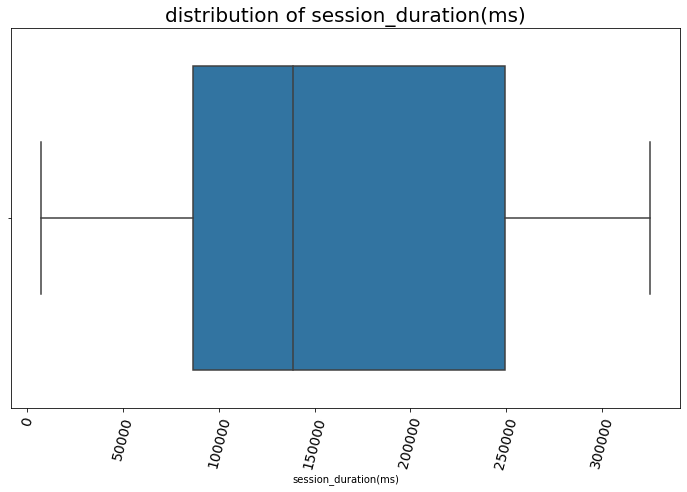

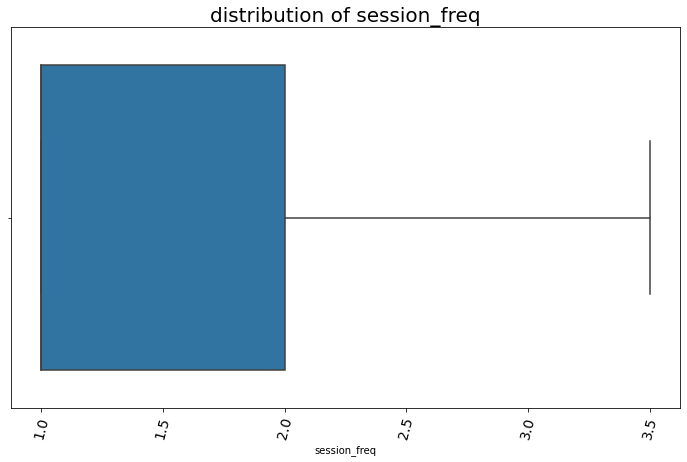

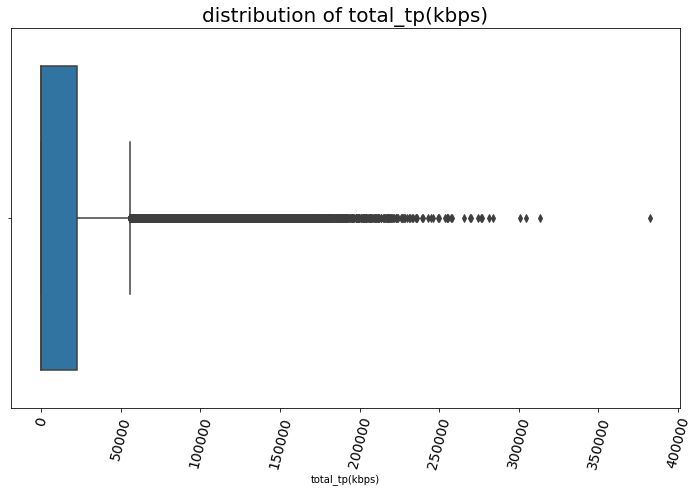

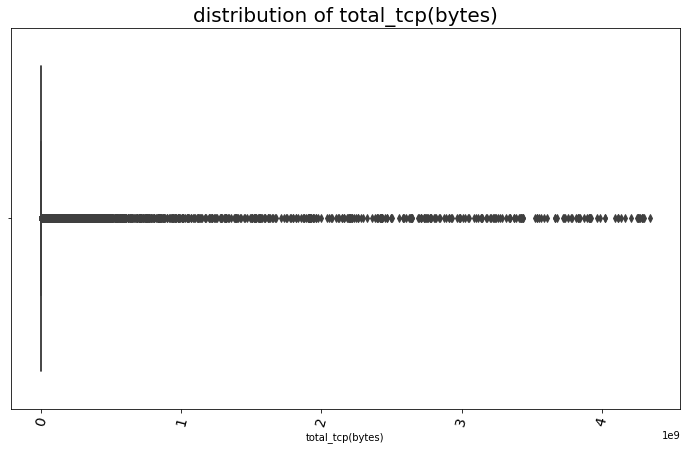

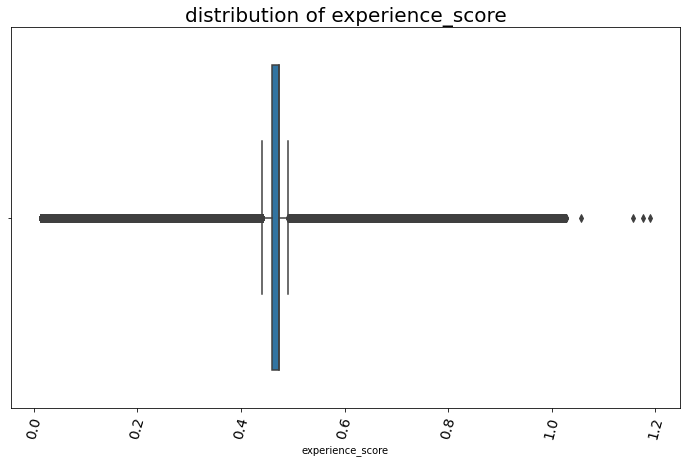

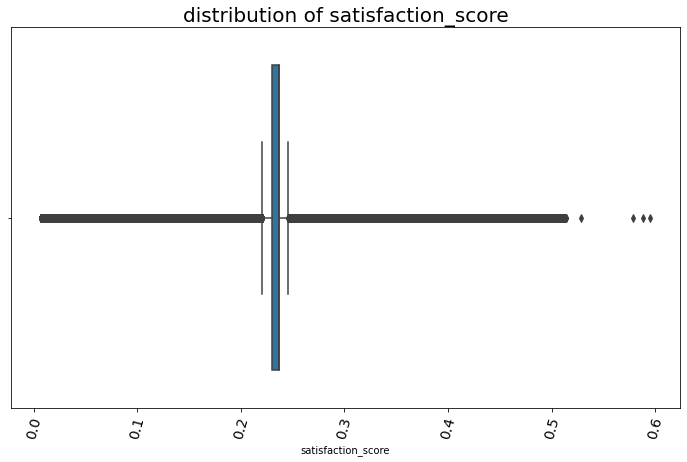

In [62]:
utility.plot_box(user_satisfaction_metrics_rearranged,'session_traffic(bytes)','distribution of session_traffic(bytes)')
utility.plot_box(user_satisfaction_metrics_rearranged,'session_duration(ms)','distribution of session_duration(ms)')
utility.plot_box(user_satisfaction_metrics_rearranged,'session_freq','distribution of session_freq')
utility.plot_box(user_satisfaction_metrics_rearranged,'total_tp(kbps)','distribution of total_tp(kbps)')
utility.plot_box(user_satisfaction_metrics_rearranged,'total_tcp(bytes)','distribution of total_tcp(bytes)')
utility.plot_box(user_satisfaction_metrics_rearranged,'experience_score','distribution of experience_score')
utility.plot_box(user_satisfaction_metrics_rearranged,'satisfaction_score','distribution of satisfaction_score')

we should handle outliers before feeding to the model

In [63]:
score_df

,msisdn,satisfaction_score,engagement_score,experience_score
0,3197020876596.0,0.237029,0.001210,0.472848
1,33601001722.0,0.236392,0.000058,0.472726
2,33601001754.0,0.236827,0.000965,0.472688
3,33601002511.0,0.236364,0.000036,0.472691
4,33601007832.0,0.231023,0.000073,0.461974
...,...,...,...,...
148930,33789980299.0,0.488361,0.000002,0.976720
148931,33789980299.0,0.236349,0.000002,0.472696
148932,33789996170.0,0.213557,0.000178,0.426936
148933,33789997247.0,0.236382,0.000103,0.472661


In [64]:
# cleaned_score_df= cleaner.handle_outliers(score_df,'session_freq')
# cleaned_score_df= cleaner.handle_outliers(cleaned_score_df,'total_tp(kbps)')
# cleaned_score_df= cleaner.handle_outliers(cleaned_score_df,'total_tcp(bytes)')
cleaned_score_df= cleaner.handle_outliers(score_df,'experience_score')
cleaned_score_df= cleaner.handle_outliers(cleaned_score_df,'engagement_score')
# cleaned_score_df= cleaner.handle_outliers(cleaned_score_df,'satisfaction_score')

In [65]:
# utility.plot_box(cleaned_score_df,'session_freq','distribution of session_freq')
# utility.plot_box(cleaned_score_df,'total_tp(kbps)','distribution of total_tp(kbps)')
# utility.plot_box(cleaned_score_df,'total_tcp(bytes)','distribution of total_tcp(bytes)')
# utility.plot_box(cleaned_score_df,'experience_score','distribution of experience_score')
# utility.plot_box(cleaned_score_df,'satisfaction_score','distribution of satisfaction_score')

Apply label encoding for handset_types

In [66]:
le = LabelEncoder()
label_encoded_satisfaction_metrics = cleaned_score_df.copy()
for col in label_encoded_satisfaction_metrics.select_dtypes(include='O').columns:
    label_encoded_satisfaction_metrics[col]=le.fit_transform(label_encoded_satisfaction_metrics[col])

In [67]:
label_encoded_satisfaction_metrics.corr()

,msisdn,satisfaction_score,engagement_score,experience_score
msisdn,1.000000,0.001360,-0.007753,-0.010916
satisfaction_score,0.001360,1.000000,0.043848,0.713667
engagement_score,-0.007753,0.043848,1.000000,0.098853
experience_score,-0.010916,0.713667,0.098853,1.000000


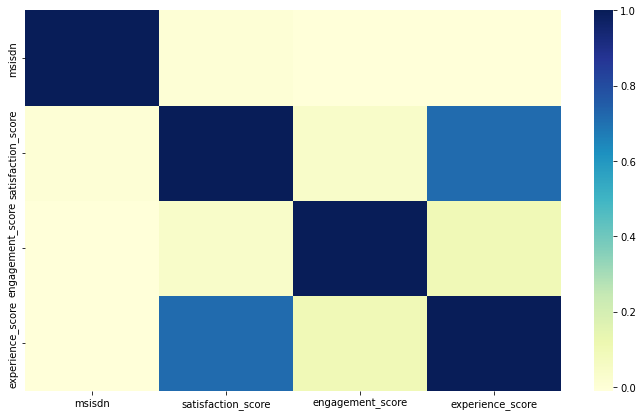

In [68]:
plt.figure(figsize=(12, 7))
sns.heatmap(label_encoded_satisfaction_metrics.corr(),cmap="YlGnBu")
plt.show()

In [69]:
# Normalize the data before clustering
normalized_score_df = cleaner.normalizer(cleaned_score_df)

In [70]:
cleaned_score_df

,msisdn,satisfaction_score,engagement_score,experience_score
0,3197020876596.0,0.237029,0.000325,0.472848
1,33601001722.0,0.236392,0.000058,0.472726
2,33601001754.0,0.236827,0.000325,0.472688
3,33601002511.0,0.236364,0.000036,0.472691
4,33601007832.0,0.231023,0.000073,0.461974
...,...,...,...,...
148930,33789980299.0,0.488361,0.000002,0.491645
148931,33789980299.0,0.236349,0.000002,0.472696
148932,33789996170.0,0.213557,0.000178,0.441146
148933,33789997247.0,0.236382,0.000103,0.472661


Build Our Model

In [71]:
# Get X and Y values for the regression model
X = normalized_score_df.loc[:,normalized_score_df.columns!="satisfaction_score" ]
# X = normalized_score_df[normalized_score_df.columns.difference(['experience_score','engagement_score','satisfaction_score'])]
# X = normalized_score_df[label_encoded_satisfaction_metrics.columns.difference(['satisfaction_score'])]
# Y = normalized_score_df[['experience_score','engagement_score','satisfaction_score']]
Y = normalized_score_df[['satisfaction_score']]

scaler=StandardScaler()
X_data=scaler.fit_transform(X)
y_data=Y.to_numpy()

# Split inpute data into train and test

x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=10)

reg = LinearRegression()

model = reg.fit(x_train, y_train)
pred = model.predict(x_test)

In [72]:
# model.score(x_test,y_test)
pred

array([[0.43980092],
       [0.2332913 ],
       [0.44196243],
       ...,
       [0.44250072],
       [0.44150164],
       [0.4418627 ]])

In [73]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=10).fit(normalized_score_df)
pred = kmeans.predict(normalized_score_df)

score_df_with_cluster = score_df.copy()
score_df_with_cluster['cluster'] = pred
score_df_with_cluster['cluster'].value_counts()

norm_score = normalized_score_df.copy()
norm_score['cluster'] = pred

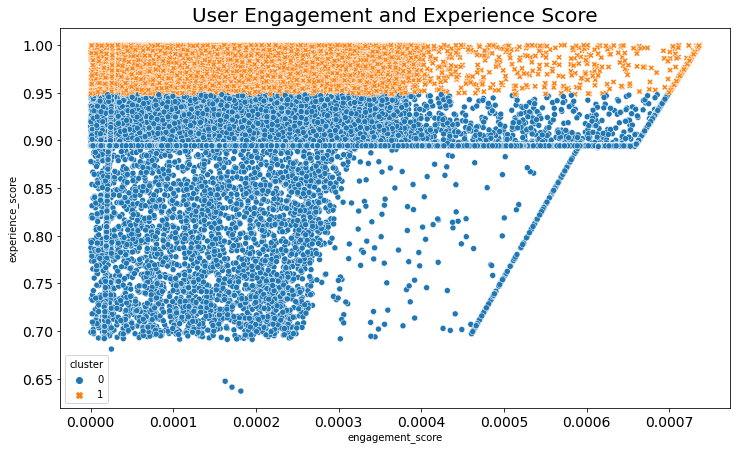

In [74]:
utility.plot_scatter(norm_score,'engagement_score', 'experience_score', 'User Engagement and Experience Score','cluster','cluster')

In [75]:
avg_cluster_scores = score_df_with_cluster.groupby(['cluster']).mean()
avg_cluster_scores.head()

,satisfaction_score,engagement_score,experience_score
cluster,,,
0,0.234191,0.000147,0.468236
1,0.082456,0.000101,0.164810


### Export final table containing all user id + engagement, experience and satisfaction scores.

In [76]:
score_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148935 entries, 0 to 148934
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   msisdn              148935 non-null  object 
 1   satisfaction_score  148935 non-null  float64
 2   engagement_score    148935 non-null  float64
 3   experience_score    148935 non-null  float64
dtypes: float64(3), object(1)
memory usage: 5.7+ MB


In [77]:
data = {
    'user_id' : 'VARCHAR(255) NOT NULL',
    'satisfaction_score' : 'FLOAT NOT NULL',
    'engagement_score' : 'FLOAT NOT NULL',
    'experience_score' : 'FLOAT NOT NULL',
}
additional_data = {
    'ENGINE' : 'InnoDB',
    'DEFAULT CHARSET' : 'utf8mb4 COLLATE utf8mb4_unicode_ci',
}

In [78]:
sql.create_and_save_schema('../data/schema.sql', "user_satisfaction", data,
                                 'user_id', additional_data=additional_data)

284

In [79]:
sql.createDB(dbName="TelCo")

In [80]:
sql.createTable(dbName='TelCo', table_schema='../data/schema.sql')
sql.alter_DB(dbName='TelCo')

In [81]:
score_df.shape

(148935, 4)

In [82]:
score_df_2 = score_df.drop_duplicates(subset=['msisdn'])
score_df_2.rename(columns={"msisdn": "user_id"}, inplace=True)

C:\Users\natnael.masresha\AppData\Local\Temp\ipykernel_25952\1108539849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df_2.rename(columns={"msisdn": "user_id"}, inplace=True)


In [83]:
a = score_df_2.reset_index()
a.drop(columns=['index'], inplace=True)
score_df_2 = a

In [84]:
sql.insert_to_table(dbName='TelCo', df=score_df_2,table_name='user_satisfaction', table_schema='../data/schema.sql')

All Data Inserted Successfully


In [85]:
values = sql.db_get_values(dbName='TelCo')
retrieve_df = pd.DataFrame(values, columns=['user_id','engagement_score','experience_score','satisfaction_score'])
retrieve_df

,user_id,engagement_score,experience_score,satisfaction_score
0,3197020876596.0,0.0,0.0,0.0
1,33601001722.0,0.0,0.0,0.0
2,33601001754.0,0.0,0.0,0.0
3,33601002511.0,0.0,0.0,0.0
4,33601007832.0,0.0,0.0,0.0
5,33601008617.0,0.0,0.0,0.0
6,33601010682.0,0.0,0.0,0.0
7,33601011634.0,0.0,0.0,0.0
8,33601011959.0,0.0,0.0,0.0
9,33601014694.0,0.0,0.0,0.0


In [86]:
agg_data = {}
agg_data['top_10_satisfied'] = top_10_satisfied
pickle.dump(agg_data, open('../models/satisfaction_data.pkl', 'wb'))